In [1]:
import numpy as np              
import matplotlib.pyplot as plt 
%matplotlib inline 
import pandas as pd             
import seaborn as sns           
import sklearn  

## Оценка вероятности выйгрыша

### 0. Описание задачи

Предположим, что вы хотите предугадать какая лошадь выйграет в данном забеге. Для этого загрузим данные о результатах скачек в Гонконге 

### 1. Загружаем данные

In [2]:
url = 'https://raw.githubusercontent.com/PlotnikovArtem/MachineLearningPractice/main/runs.csv'
data = pd.read_csv(url, delimiter='\t',  engine='python')

Таблица содержит данные о более 79 тысяч конных забегов в 6349 гонках которые проходили в Гонконге. Для каждого забега указано финишное положение данной лошади в гонке, выиграла ли лошадь (1) или иначе (0), пол лошади (Gelding', 'Mare', 'Horse', 'Rig', 'Colt', 'Filly'), финишное время лошади в этой гонке (сек), шансы на победу этой лошади в начале гонки и многие другие признаки.

Вначале посмотрим на размеры таблицы - количество строк (каждая строка соответствует одному конному пробегу в одной из гонок) и количество столбцов (каждый столбец соответствует конкретному признаку):

In [3]:
data.shape

(79447, 16)

In [4]:
data

,race_id,horse_no,horse_id,result,won,lengths_behind,horse_age,horse_country,horse_type,horse_rating,declared_weight,actual_weight,draw,finish_time,win_odds,place_odds
0,0,1,3917,10,0.0,8.00,3,AUS,Gelding,60,1020.0,133,7,83.92,9.7,3.7
1,0,2,2157,8,0.0,5.75,3,NZ,Gelding,60,980.0,133,12,83.56,16.0,4.9
2,0,3,858,7,0.0,4.75,3,NZ,Gelding,60,1082.0,132,8,83.40,3.5,1.5
3,0,4,1853,9,0.0,6.25,3,SAF,Gelding,60,1118.0,127,13,83.62,39.0,11.0
4,0,5,2796,6,0.0,3.75,3,GB,Gelding,60,972.0,131,14,83.24,50.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79442,6348,10,1238,6,0.0,1.25,5,AUS,Gelding,87,1191.0,122,6,96.17,99.0,NaN
79443,6348,11,985,7,0.0,2.25,5,NZ,Gelding,84,1070.0,119,4,96.30,99.0,NaN
79444,6348,12,3147,10,0.0,3.00,5,NZ,Gelding,83,1148.0,120,1,96.44,99.0,NaN
79445,6348,13,1982,8,0.0,2.50,3,AUS,Gelding,82,1266.0,119,12,96.34,4.6,NaN


Столбцы (признаки) имеют имена

 - race_id - уникальный идентификатор для гонки
 - horse_no - номер, присвоенный этой лошади, в гонке
 - horse_id - уникальный идентификатор для данной лошади
 - result - финишная позиция данной лошади в забеге
 - won - выиграла лошадь (1) или нет (0)
 - lengths_behind - финишная позиция, как количество лошадиных длин позади победителя
 - horse_age - текущий возраст этой лошади на момент гонки
 - horse_country - страна происхождения этой лошади
 - horse_type - пол лошади (например, 'Gelding', 'Mare', 'Horse', 'Rig', 'Colt', 'Filly')
 - horse_rating - рейтинговый номер, присвоенный HKJC данной лошади во время гонки
 - declared_weight - заявленный вес лошади и жокея, в фунтах
 - actual_weight - фактический вес, переносимый лошадью, в фунтах
 - draw - номер позиции лошади в этом забеге
 - finish_time - время финиша лошади в этой гонке (sec)
 - win_odds - шансы на победу этой лошади в начале гонки
 - place_odds - коэффициенты призовых мест для этой лошади в начале гонки

Признак won (целевой) - бинарный, horse_country, horse_type, horse_gear - номинальный (категориальный), остальные признаки - количественные (числовые).

Задача прогнозирования состоит в том, чтобы определить, какая лошадь выйграет в данном забеге.

Столбцы 'horse_country' и 'horse_type' содержат категориальные значения. Пока они имеют тип 'Object'. Заменим тип на специальный, предназначенный для хранения категориальных значений:

In [5]:
data['horse_country'] = data['horse_country'].astype('category')

In [6]:
data['horse_type'] = data['horse_type'].astype('category')

Проверим, что теперь данные столбцы соответсвуют категориальным значениям

In [7]:
data['horse_country'].dtype 

CategoricalDtype(categories=['ARG', 'AUS', 'BRZ', 'CAN', 'FR', 'GB', 'GER', 'GR', 'IRE',
                  'ITY', 'JPN', 'NZ', 'SAF', 'SPA', 'USA', 'ZIM'],
, ordered=False)

### 3. Визуализация данных и вычисление основных характеристик

Получим сводную информацию о признаках:

In [8]:
data.describe()

,race_id,horse_no,horse_id,result,won,lengths_behind,horse_age,horse_rating,declared_weight,actual_weight,draw,finish_time,win_odds,place_odds
count,79447.000000,79447.000000,79447.000000,79447.000000,79447.000000,79447.000000,79447.000000,79447.000000,79447.000000,79447.000000,79447.000000,79447.000000,79447.000000,75712.000000
mean,3173.352814,6.905623,2204.410525,6.838597,0.080053,6.108901,3.339346,61.034904,1104.953568,122.729656,6.876005,85.322914,28.812977,7.423177
std,1833.101494,3.760711,1275.049375,3.730498,0.271378,33.636209,0.876763,11.748788,62.347597,6.305496,3.747589,18.512883,30.097375,8.823430
min,0.000000,1.000000,0.000000,1.000000,0.000000,-0.500000,2.000000,10.000000,693.000000,103.000000,1.000000,55.160000,1.000000,1.000000
25%,1586.000000,4.000000,1085.000000,4.000000,0.000000,1.750000,3.000000,60.000000,1062.000000,118.000000,4.000000,70.590000,7.700000,2.400000
50%,3174.000000,7.000000,2209.000000,7.000000,0.000000,4.000000,3.000000,60.000000,1102.000000,123.000000,7.000000,83.350000,15.000000,4.100000
75%,4764.500000,10.000000,3308.000000,10.000000,0.000000,6.750000,3.000000,60.000000,1146.000000,128.000000,10.000000,100.780000,38.000000,8.600000
max,6348.000000,14.000000,4404.000000,14.000000,1.000000,999.000000,10.000000,138.000000,1369.000000,133.000000,15.000000,163.580000,99.000000,101.000000


Получим информацию о категориальных:

In [9]:
data.describe(include=['category'])

,horse_country,horse_type
count,79445,79445
unique,16,9
top,AUS,Gelding
freq,29906,75503


Построим диаграмму рассеивания для признаков 'result', 'win_odds':

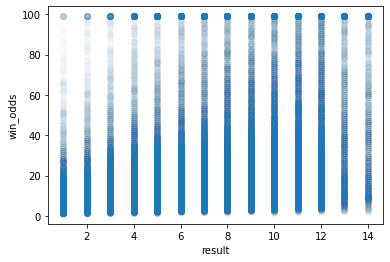

In [10]:
plt.scatter(data['result'], data['win_odds'], alpha=0.01)
plt.xlabel('result')
plt.ylabel('win_odds')
pass

Из рисунка видно, что, по-видимому, никакой зависимости между финишной позицией и рейтингом данной лошади нет.

Для отрисовки диаграммы рассеивания воспользуемся функцией scatterplot. Например, в следующей диаграмме цвет маркеров соответствует стране происхождения 'horse_country', а размер - занимает признак 'win_odds':

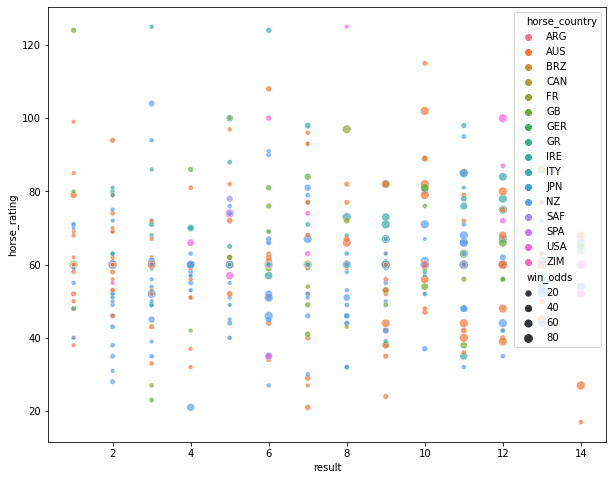

In [11]:
np.random.seed(42)
random_subset = np.random.choice(np.arange(data.shape[0]), size=1000, replace=False)
plt.figure(figsize = (10, 8))
sns.scatterplot(x='result', y='horse_rating', size='win_odds', hue='horse_country', data=data.iloc[random_subset], alpha=0.7)
pass

Можно увидеть, что параметр win_odds часто ошибочен, и лошади с маленьким шансом на победу часто выигрывают в гонках. Также можно заметить, что чаще победителями гонок являются лошади из ARG, AUS, NZ. 

Построим гистограмму с помощью функции distplot из библиотеки seaborn.

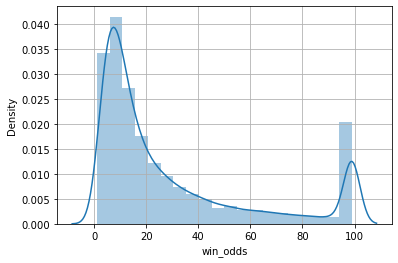

In [12]:
sns.distplot(data['win_odds'], bins=20)
plt.grid()
pass

представим вместе диаграмму рассеивания для пары признаков и соответствующие гистограммы:

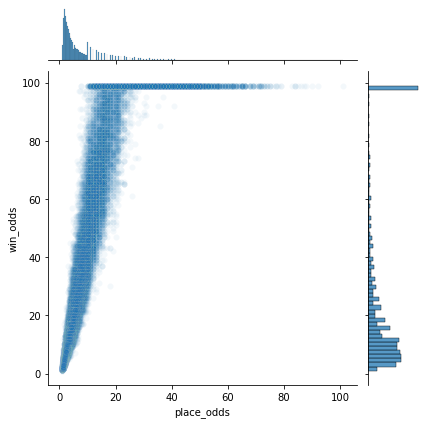

In [13]:
sns.jointplot(x='place_odds', y='win_odds', alpha=.05, data=data)
pass

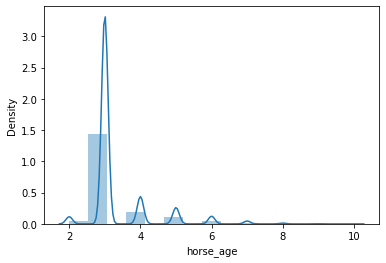

In [14]:
sns.distplot(data['horse_age'], bins = 15)
pass

Построим ящик с усами для признаков 'result'и 'horse_contry':

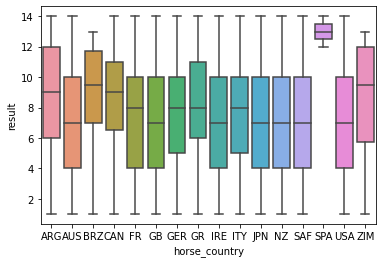

In [15]:
sns.boxplot(x="horse_country", y="result", data=data)
pass

Также информацию о характере распределения получим из скрипичных графиков:

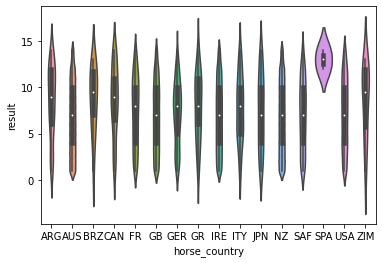

In [16]:
sns.violinplot(x="horse_country", y="result", data=data)
pass

Вычислим матрицу корреляции для количественных признаков:

In [17]:
corr_mat = data.corr()
corr_mat

,race_id,horse_no,horse_id,result,won,lengths_behind,horse_age,horse_rating,declared_weight,actual_weight,draw,finish_time,win_odds,place_odds
race_id,1.000000,0.000104,-0.053543,-0.000257,0.000136,-0.039257,0.446711,0.058439,0.044864,0.048939,0.000627,-0.027027,0.041778,0.037380
horse_no,0.000104,1.000000,0.003719,0.111750,-0.052069,0.009799,-0.016498,-0.146383,-0.044488,-0.800251,0.025817,0.002032,0.200639,0.183137
horse_id,-0.053543,0.003719,1.000000,0.000164,-0.002705,-0.001623,-0.015791,0.006833,-0.010505,-0.012989,-0.001943,0.009712,0.000669,-0.000737
result,-0.000257,0.111750,0.000164,1.000000,-0.461693,0.161916,-0.023854,-0.028626,-0.034051,-0.094573,0.125884,0.031713,0.470562,0.439904
won,0.000136,-0.052069,-0.002705,-0.461693,1.000000,-0.053576,-0.004351,0.013983,0.028933,0.051097,-0.048595,-0.012723,-0.190790,-0.156188
lengths_behind,-0.039257,0.009799,-0.001623,0.161916,-0.053576,1.000000,-0.016083,-0.008669,-0.001053,-0.010793,0.021921,0.037315,0.089541,0.089060
horse_age,0.446711,-0.016498,-0.015791,-0.023854,-0.004351,-0.016083,1.000000,0.045588,0.008069,0.006164,-0.009976,0.079138,-0.022757,-0.046705
horse_rating,0.058439,-0.146383,0.006833,-0.028626,0.013983,-0.008669,0.045588,1.000000,0.069133,0.078515,-0.015443,-0.002670,0.000412,-0.010425
declared_weight,0.044864,-0.044488,-0.010505,-0.034051,0.028933,-0.001053,0.008069,0.069133,1.000000,0.041835,0.000501,-0.112496,-0.062057,-0.071939
actual_weight,0.048939,-0.800251,-0.012989,-0.094573,0.051097,-0.010793,0.006164,0.078515,0.041835,1.000000,0.002128,0.007860,-0.200862,-0.173438


Воспользуемся визуальным образом этой матрицы. Чем светлее ячейка, тем больше по абсолютной величине коэффициент корреляции:

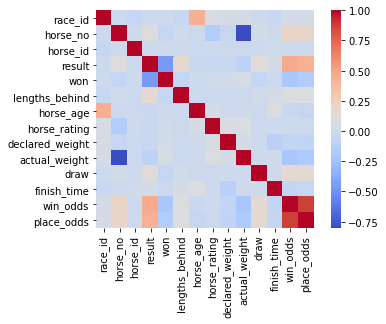

In [18]:
sns.heatmap(corr_mat, square=True, cmap='coolwarm')
pass

Выведем коэффициенты корреляции, больше заданного значения:

In [19]:
corr_mat > 0.4

,race_id,horse_no,horse_id,result,won,lengths_behind,horse_age,horse_rating,declared_weight,actual_weight,draw,finish_time,win_odds,place_odds
race_id,True,False,False,False,False,False,True,False,False,False,False,False,False,False
horse_no,False,True,False,False,False,False,False,False,False,False,False,False,False,False
horse_id,False,False,True,False,False,False,False,False,False,False,False,False,False,False
result,False,False,False,True,False,False,False,False,False,False,False,False,True,True
won,False,False,False,False,True,False,False,False,False,False,False,False,False,False
lengths_behind,False,False,False,False,False,True,False,False,False,False,False,False,False,False
horse_age,True,False,False,False,False,False,True,False,False,False,False,False,False,False
horse_rating,False,False,False,False,False,False,False,True,False,False,False,False,False,False
declared_weight,False,False,False,False,False,False,False,False,True,False,False,False,False,False
actual_weight,False,False,False,False,False,False,False,False,False,True,False,False,False,False


In [20]:
corr_mat.where(np.triu(corr_mat > 0.4, k=1)).stack().sort_values(ascending=False)

win_odds  place_odds    0.880301
result    win_odds      0.470562
race_id   horse_age     0.446711
result    place_odds    0.439904
dtype: float64

Обратите внимание на отрицательную корреляцию между финишной позицией лошади и ее рейтингом

In [21]:
corr_mat.loc['result', 'horse_rating']

-0.028626281722819835

Посмотрим, сколько раз номинальные переменные принимают то или иное значение

In [22]:
data['horse_type'].value_counts()

Gelding    75503
Brown       2044
Horse       1093
Colt         305
Mare         238
Rig          154
Roan          48
Filly         43
Grey          17
Name: horse_type, dtype: int64

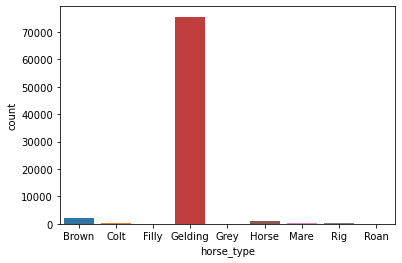

In [23]:
sns.countplot(x='horse_type', data=data)
pass

In [24]:
data['horse_country'].value_counts()

AUS    29906
NZ     27497
IRE    10473
GB      6329
USA     2499
FR      1257
SAF      685
GER      357
ARG      127
JPN       93
CAN       91
ITY       66
GR        33
BRZ       18
ZIM       12
SPA        2
Name: horse_country, dtype: int64

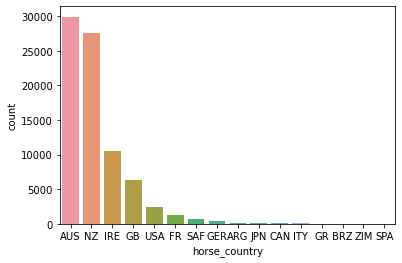

In [25]:
sns.countplot(x='horse_country', order=data['horse_country'].value_counts().index, data=data)
pass

Посмотри, сколько раз каждая из стран занимала первое место:

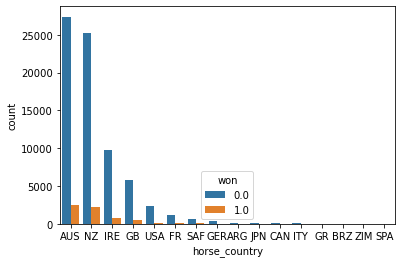

In [26]:
sns.countplot(x='horse_country', order=data['horse_country'].value_counts().index, hue='won', data=data)
pass

### 4. Обработка пропущеных значений

In [27]:
data.isna().sum()

race_id               0
horse_no              0
horse_id              0
result                0
won                   0
lengths_behind        0
horse_age             0
horse_country         2
horse_type            2
horse_rating          0
declared_weight       0
actual_weight         0
draw                  0
finish_time           0
win_odds              0
place_odds         3735
dtype: int64

Заполним медианами пропущенные значения в столбцах, соответствующих числовым признакам:

In [28]:
data.fillna(data.median(axis = 0), axis=0 , inplace=True)

Пропущенные значения в столбцах, соответствующих категориальным признакам, заполним модой:

In [29]:
data['horse_country'].fillna(data['horse_country'].mode().iloc[0], inplace=True)
data['horse_type'].fillna(data['horse_type'].mode().iloc[0], inplace=True)

In [30]:
data.isna().sum()

race_id            0
horse_no           0
horse_id           0
result             0
won                0
lengths_behind     0
horse_age          0
horse_country      0
horse_type         0
horse_rating       0
declared_weight    0
actual_weight      0
draw               0
finish_time        0
win_odds           0
place_odds         0
dtype: int64

In [31]:
data.describe()

,race_id,horse_no,horse_id,result,won,lengths_behind,horse_age,horse_rating,declared_weight,actual_weight,draw,finish_time,win_odds,place_odds
count,79447.000000,79447.000000,79447.000000,79447.000000,79447.000000,79447.000000,79447.000000,79447.000000,79447.000000,79447.000000,79447.000000,79447.000000,79447.000000,79447.000000
mean,3173.352814,6.905623,2204.410525,6.838597,0.080053,6.108901,3.339346,61.034904,1104.953568,122.729656,6.876005,85.322914,28.812977,7.266947
std,1833.101494,3.760711,1275.049375,3.730498,0.271378,33.636209,0.876763,11.748788,62.347597,6.305496,3.747589,18.512883,30.097375,8.642198
min,0.000000,1.000000,0.000000,1.000000,0.000000,-0.500000,2.000000,10.000000,693.000000,103.000000,1.000000,55.160000,1.000000,1.000000
25%,1586.000000,4.000000,1085.000000,4.000000,0.000000,1.750000,3.000000,60.000000,1062.000000,118.000000,4.000000,70.590000,7.700000,2.400000
50%,3174.000000,7.000000,2209.000000,7.000000,0.000000,4.000000,3.000000,60.000000,1102.000000,123.000000,7.000000,83.350000,15.000000,4.100000
75%,4764.500000,10.000000,3308.000000,10.000000,0.000000,6.750000,3.000000,60.000000,1146.000000,128.000000,10.000000,100.780000,38.000000,8.200000
max,6348.000000,14.000000,4404.000000,14.000000,1.000000,999.000000,10.000000,138.000000,1369.000000,133.000000,15.000000,163.580000,99.000000,101.000000


In [32]:
data.describe(include=['category'])

,horse_country,horse_type
count,79447,79447
unique,16,9
top,AUS,Gelding
freq,29908,75505


### 5. Обработка категориальных признаков 

К категориальным признакам 'horse_country' и 'horse_type' применим метод бинаризации:

In [33]:
horse_country_dummies = pd.get_dummies(data['horse_country'])
horse_type_dummies = pd.get_dummies(data['horse_type'])

In [34]:
horse_country_dummies.head()

,ARG,AUS,BRZ,CAN,FR,GB,GER,GR,IRE,ITY,JPN,NZ,SAF,SPA,USA,ZIM
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [35]:
horse_type_dummies.head()

,Brown,Colt,Filly,Gelding,Grey,Horse,Mare,Rig,Roan
0,0,0,0,1,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0


Добавим эти dummy-столбцы к таблице и удалим столбцы horse_country и horse_type:

In [36]:
data = pd.concat((data, horse_country_dummies), axis=1)
data = pd.concat((data, horse_type_dummies), axis=1)
data = data.drop(['horse_country', 'horse_type'], axis=1)

In [37]:
data.head()

,race_id,horse_no,horse_id,result,won,lengths_behind,horse_age,horse_rating,declared_weight,actual_weight,...,ZIM,Brown,Colt,Filly,Gelding,Grey,Horse,Mare,Rig,Roan
0,0,1,3917,10,0.0,8.00,3,60,1020.0,133,...,0,0,0,0,1,0,0,0,0,0
1,0,2,2157,8,0.0,5.75,3,60,980.0,133,...,0,0,0,0,1,0,0,0,0,0
2,0,3,858,7,0.0,4.75,3,60,1082.0,132,...,0,0,0,0,1,0,0,0,0,0
3,0,4,1853,9,0.0,6.25,3,60,1118.0,127,...,0,0,0,0,1,0,0,0,0,0
4,0,5,2796,6,0.0,3.75,3,60,972.0,131,...,0,0,0,0,1,0,0,0,0,0


### 6. Нормализация количественных признаков

Выполним стандартизацию всех признаков:

In [38]:
data_stand = (data - data.mean(axis = 0))/data.std(axis = 0)
data_stand.describe()

,race_id,horse_no,horse_id,result,won,lengths_behind,horse_age,horse_rating,declared_weight,actual_weight,...,ZIM,Brown,Colt,Filly,Gelding,Grey,Horse,Mare,Rig,Roan
count,7.944700e+04,7.944700e+04,7.944700e+04,7.944700e+04,7.944700e+04,7.944700e+04,7.944700e+04,7.944700e+04,7.944700e+04,7.944700e+04,...,7.944700e+04,7.944700e+04,7.944700e+04,7.944700e+04,7.944700e+04,7.944700e+04,7.944700e+04,7.944700e+04,7.944700e+04,7.944700e+04
mean,-5.303788e-15,-3.725292e-17,-4.205200e-16,2.369161e-16,1.800907e-16,-6.441268e-15,3.185956e-14,-3.872969e-14,-1.712356e-15,-3.874602e-15,...,-1.517767e-14,2.322265e-14,3.447295e-14,4.399669e-15,-2.126771e-14,5.236687e-15,-3.056130e-14,3.812651e-15,6.396766e-15,1.452883e-14
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.731139e+00,-1.570348e+00,-1.728882e+00,-1.565099e+00,-2.949890e-01,-1.964817e-01,-1.527602e+00,-4.343844e+00,-6.607369e+00,-3.128962e+00,...,-1.229085e-02,-1.625020e-01,-6.207885e-02,-2.327075e-02,-4.376499e+00,-1.462950e-02,-1.181073e-01,-5.481488e-02,-4.406971e-02,-2.458727e-02
25%,-8.659383e-01,-7.726260e-01,-8.779350e-01,-7.609163e-01,-2.949890e-01,-1.295895e-01,-3.870437e-01,-8.808600e-02,-6.889370e-01,-7.500847e-01,...,-1.229085e-02,-1.625020e-01,-6.207885e-02,-2.327075e-02,2.284903e-01,-1.462950e-02,-1.181073e-01,-5.481488e-02,-4.406971e-02,-2.458727e-02
50%,3.530553e-04,2.509563e-02,3.599449e-03,4.326586e-02,-2.949890e-01,-6.269734e-02,-3.870437e-01,-8.808600e-02,-4.737260e-02,4.287431e-02,...,-1.229085e-02,-1.625020e-01,-6.207885e-02,-2.327075e-02,2.284903e-01,-1.462950e-02,-1.181073e-01,-5.481488e-02,-4.406971e-02,-2.458727e-02
75%,8.680082e-01,8.228172e-01,8.655269e-01,8.474481e-01,-2.949890e-01,1.905979e-02,-3.870437e-01,-8.808600e-02,6.583483e-01,8.358334e-01,...,-1.229085e-02,-1.625020e-01,-6.207885e-02,-2.327075e-02,2.284903e-01,-1.462950e-02,-1.181073e-01,-5.481488e-02,-4.406971e-02,-2.458727e-02
max,1.731845e+00,1.886446e+00,1.725101e+00,1.919691e+00,3.389915e+00,2.951852e+01,7.596867e+00,6.550897e+00,4.235070e+00,1.628792e+00,...,8.136031e+01,6.153691e+00,1.610834e+01,4.297187e+01,2.284903e-01,6.835418e+01,8.466770e+00,1.824299e+01,2.269104e+01,4.067094e+01


### 7. Отбор признаков

In [39]:
data_stand.columns

Index(['race_id', 'horse_no', 'horse_id', 'result', 'won', 'lengths_behind',
       'horse_age', 'horse_rating', 'declared_weight', 'actual_weight', 'draw',
       'finish_time', 'win_odds', 'place_odds', 'ARG', 'AUS', 'BRZ', 'CAN',
       'FR', 'GB', 'GER', 'GR', 'IRE', 'ITY', 'JPN', 'NZ', 'SAF', 'SPA', 'USA',
       'ZIM', 'Brown', 'Colt', 'Filly', 'Gelding', 'Grey', 'Horse', 'Mare',
       'Rig', 'Roan'],
      dtype='object')

In [40]:
X = data_stand.drop(['horse_id', 'won'], axis=1)
y = data['won']

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 

N_train, N_test

(59585, 19862)

### 8. Метод к-ближайших соседей

Cоздадим модель для метода к-ближайших соседей и обучим её:

In [42]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 10)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

На обученную модель подаем обучаемую выборку и вычисляем ошибку:

In [43]:
y_train_predict = knn.predict(X_train)
err_test_1  = np.mean(y_train  != y_train_predict)
err_test_1

0.06144163799613997

На обученную модель подаем тестовую выборку и вычисляем ошибку:

In [44]:
y_test_predict = knn.predict(X_test)
err_test_2  = np.mean(y_test  != y_test_predict)
err_test_2

0.06817037559158191

Изменим параметр метода k-ближайших соседей и выведем ошибки для обучаемой и тестовой выборки:

In [45]:
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(X_train, y_train)

y_train_predict = knn.predict(X_train)
err_test_1  = np.mean(y_train  != y_train_predict)
print(err_test_1)

y_test_predict = knn.predict(X_test)
err_test_2  = np.mean(y_test  != y_test_predict)
print(err_test_2)

0.0
0.0717450407813916


In [46]:
knn = KNeighborsClassifier(n_neighbors = 2)
knn.fit(X_train, y_train)

y_train_predict = knn.predict(X_train)
err_test_1  = np.mean(y_train  != y_train_predict)
print(err_test_1)

y_test_predict = knn.predict(X_test)
err_test_2  = np.mean(y_test  != y_test_predict)
print(err_test_2)

0.043836536040949906
0.06827107038566106


In [47]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)

y_train_predict = knn.predict(X_train)
err_test_1  = np.mean(y_train  != y_train_predict)
print(err_test_1)

y_test_predict = knn.predict(X_test)
err_test_2  = np.mean(y_test  != y_test_predict)
print(err_test_2)

0.04434001846102207
0.06258181452018931


In [48]:
knn = KNeighborsClassifier(n_neighbors = 15)
knn.fit(X_train, y_train)

y_train_predict = knn.predict(X_train)
err_test_1  = np.mean(y_train  != y_train_predict)
print(err_test_1)

y_test_predict = knn.predict(X_test)
err_test_2  = np.mean(y_test  != y_test_predict)
print(err_test_2)

0.06150876898548292
0.06585439532776155


### Выводы
В рамках данной работы были изучено:

 1. Работа с библиотеками для Python и машинного обучения;
 2. Методы визуализации данных и вычисление основных характеристик;
 3. Методы обработки пропущенных значений и категориальных признаков;
 4. Методы проведения нормализации данных.
 5. Методы разбиения данных на выборки;
 6. Использование метода "k-ближаших соседей".
 
Касательно метода "k-ближаших соседей": были опыты с изменением параметров модели (1, 2, 5, 10, 15) и с запуском обученной модели на "тестовой" и "обучаемой" выборке.

Исходя из полученных данных можно сделать следующие выводы:

 1. При запуске модели на обучаемой выборке с уменьшением параметра модели ошибка уменьшается - с уменьшением параметра поведение модели стремится к полному перебору данных из тренировочной выборки.
 2. При запуске модели на тестовой выборке с увеличением параметра модели ошибка уменьшается - чем больше объектов мы берем в рассмотрение тем более точно определяется отношение объекта к одному из двух классов.